# Basic transfer learning with cats and dogs data

In this notebook, we will delve into basic transfer learning techniques using the Cats and Dogs dataset. We'll leverage pre-trained models to improve our ability to distinguish between images of cats and dogs, setting the stage for more sophisticated image classification tasks.

### Import modules

In [ ]:
import urllib.request
import os
import zipfile
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from shutil import copyfile
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from keras.preprocessing import image

### Download the cats and dogs dataset.

In [ ]:
data_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
data_file_name = "cats_and_dogs_filtered.zip"
download_dir = '/content/dataset/'

urllib.request.urlretrieve(data_url, data_file_name)
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()


Let's ensure the dataset contains the expected number of examples. Checking this helps confirm that our data is complete and ready for the subsequent steps in our analysis or model training.

In [ ]:
print("Number of cat images:",len(os.listdir('/content/dataset/cats_and_dogs_filtered/train/cats')))
print("Number of dog images:", len(os.listdir('/content/dataset/cats_and_dogs_filtered/train/dogs')))

Number of cat images: 1000
Number of dog images: 1000


Let's verify that the training and test sets are of the expected lengths. This check ensures that our data has been correctly partitioned and is ready for use in model training and evaluation.

In [ ]:
print("Number of training cat images", len(os.listdir('/content/dataset/cats_and_dogs_filtered/train/cats')))
print("Number of training dog images", len(os.listdir('/content/dataset/cats_and_dogs_filtered/train/dogs')))
print("Number of testing cat images", len(os.listdir('/content/dataset/cats_and_dogs_filtered/validation/cats')))
print("Number of testing dog images", len(os.listdir('/content/dataset/cats_and_dogs_filtered/validation/dogs')))

Number of training cat images 1000
Number of training dog images 1000
Number of testing cat images 500
Number of testing dog images 500


### Data augmentation

Here, we'll utilize the `ImageDataGenerator` for data augmentation, which involves rotating and flipping the existing images. This technique helps generate a more varied training dataset and enhances the model's ability to generalize during training. Additionally, the same data augmentation methods can be applied to the validation set to maintain consistency in data processing.

Initially, use the default parameters of `ImageDataGenerator`. Once familiar with the baseline performance, experiment with different parameters to potentially improve the model's performance. Aim to achieve a validation accuracy of 99.9% or better through these adjustments.

In [ ]:
TRAINING_DIR = "/content/dataset/cats_and_dogs_filtered/train/"

train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=45,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.1,
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = "/content/dataset/cats_and_dogs_filtered/validation"

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### Get and prepare the model

We'll be leveraging the `InceptionV3` model for our transfer learning project. Here’s how we'll proceed:

- We'll load the model with pre-trained weights, capitalizing on the learned features from a broader dataset.
- To maintain the integrity of the learned features, we'll freeze the existing layers of the model. This prevents them from being updated during training on our specific cats and dogs dataset.
- We'll specifically reference the 'mixed7' layer, as this will serve as the point where we'll append additional layers tailored to our task. This strategy helps in fine-tuning the model to better suit our classification needs.

In [ ]:
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"
urllib.request.urlretrieve(weights_url, weights_file)

# Instantiate the model
pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top=False,
                                weights=None)

# Load pre-trained weights
pre_trained_model.load_weights(weights_file)

# Freeze the layers
for layer in pre_trained_model.layers:
    layer.trainable = False

# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output



last layer output shape:  (None, 7, 7, 768)


### Add layers

To tailor the `InceptionV3` model for our classification task between cats and dogs, we will add several layers that will be trained specifically on our dataset:

- **Flatten Layer**: First, we'll take the output from the 'mixed7' layer and flatten it. This transformation converts the multi-dimensional output into a single long vector, which serves as the input for the subsequent dense layers.

- **Dense Layer with ReLU Activation**: Next, we will add a dense layer that introduces non-linearity to the model. The ReLU (rectified linear unit) activation function is used here to help the network learn complex patterns in the data.

- **Dense Layer with Sigmoid Activation**: Following the ReLU layer, another dense layer will be added with a sigmoid activation function. This layer will output a single value between 0 and 1, effectively allowing us to classify the input as either a cat (closer to 0) or a dog (closer to 1).

After adding these layers, we will create the model object. This final model will incorporate the pre-trained InceptionV3 up to the 'mixed7' layer with our added layers on top, fully configured to perform our specific task of classifying cats and dogs. This approach harnesses the power of transfer learning while providing the flexibility to focus on our particular classification challenge.

In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1,   activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

### Train the Model

Next, we will compile the model and proceed to train it on our dataset:

- **Compile the Model**: Before training, we'll compile the model by specifying the optimizer, loss function, and metrics to track. This step configures the model for efficient learning and evaluation.

- **Training the Model**: We'll use the `model.fit` method to train the model on the dataset. Initially designed to run for 20 epochs, we can adjust this to a smaller number, like 2 epochs, for a quicker initial run. This allows us to verify that the code is functioning correctly without waiting for the full training process.

- **Handling Warnings**: During training, we may encounter warnings about corrupt EXIF data in some images. These images will be skipped automatically, so these warnings can be safely ignored.

This approach provides a balance between seeing rapid results and setting up for more extensive training sessions if needed. By starting with fewer epochs, we can quickly assess the model's initial performance and make any necessary adjustments before committing to a longer training period.

In [ ]:
# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['acc'])

# Train the model
history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=5,
            verbose=1)

Epoch 1/5
20/20 [==============================] - 167s 8s/step - loss: 0.7781 - acc: 0.7360 - val_loss: 0.1619 - val_acc: 0.9440
Epoch 2/5
20/20 [==============================] - 152s 8s/step - loss: 0.3475 - acc: 0.8375 - val_loss: 0.1437 - val_acc: 0.9470
Epoch 3/5
20/20 [==============================] - 152s 8s/step - loss: 0.3041 - acc: 0.8620 - val_loss: 0.1256 - val_acc: 0.9510
Epoch 4/5
20/20 [==============================] - 159s 8s/step - loss: 0.2530 - acc: 0.8925 - val_loss: 0.1021 - val_acc: 0.9590
Epoch 5/5
20/20 [==============================] - 153s 8s/step - loss: 0.2551 - acc: 0.8890 - val_loss: 0.1856 - val_acc: 0.9200


### Visualize the training and validation accuracy

After training, it's insightful to visualize the changes in training and validation accuracy across epochs. We will plot these metrics on an x-y graph:

- **X-axis**: Represents the number of epochs, indicating the progression of training over time.
- **Y-axis**: Displays the accuracy values, showing how the model's performance on the training and validation sets improves with each epoch.

This visual representation helps us easily track and analyze the model's learning trajectory, identify patterns such as overfitting or underfitting, and determine the optimal number of training epochs based on performance stabilization.

<Figure size 640x480 with 0 Axes>

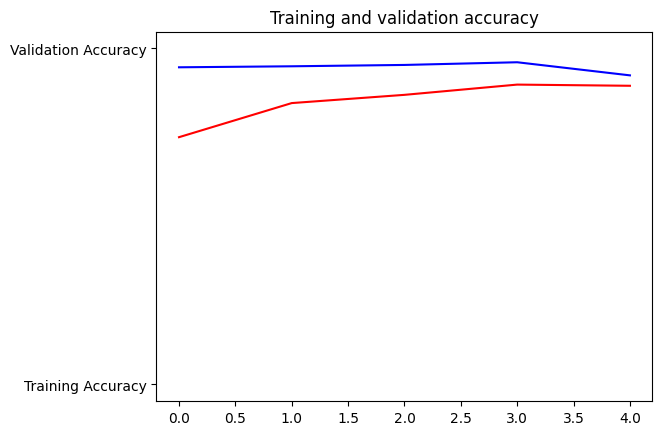

<Figure size 640x480 with 0 Axes>

In [ ]:
# Retrieve a list of list results on training and test data sets for each training epoch
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

# Get number of epochs
epochs=range(len(acc))


# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

### Predict on a test image

Once the model is trained, we can test its predictive capabilities with real-world images:

- **Image Selection**: Find an image of a dog or cat that we'd like to test the model on. This could be an image from personal collection or one sourced from the internet.

- **Image Upload**: Run the provided code cell, which includes functionality for uploading an image. This step is user-friendly and allows to interact directly with the model.

- **Model Prediction**: After the image is uploaded, the model will process the image and make a prediction. Based on the output value from the sigmoid activation layer, the model will classify the image and print either "is a dog" or "is a cat."

This feature not only showcases the practical application of our model but also provides a direct way to interact with the machine learning system, making the experience more engaging and informative.

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():

  # Predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  print(classes)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a dog")
  else:
    print(fn + " is a cat")

Saving Dog Test.jpg to Dog Test (1).jpg
1/1 [==============================] - 1s 1s/step
[[1.]]
[1.]
Dog Test (1).jpg is a dog
